In [34]:
# Imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from neuralsens import partial_derivatives as ns

from mltools import classification_tools as CT
from mltools import model_tools as MT

# EDA

In [2]:
# Import dataset
df = pd.read_csv('Diabetes.csv', sep=';')
df.head()

PREGNANT  GLUCOSE  BLOODPRESS  SKINTHICKNESS  INSULIN  BODYMASSINDEX  \
0         6      148          72             35        0           33.6   
1         1       85          66             29        0           26.6   
2         8      183          64              0        0           23.3   
3         1       89          66             23       94           28.1   
4         0      137          40             35      168           43.1   

   PEDIGREEFUNC  AGE  DIABETES  
0         0.627   50         1  
1         0.351   31         0  
2         0.672   32         1  
3         0.167   21         0  
4         2.288   33         1

In [3]:
# Missing values
df.info()
# No missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PREGNANT       768 non-null    int64  
 1   GLUCOSE        768 non-null    int64  
 2   BLOODPRESS     768 non-null    int64  
 3   SKINTHICKNESS  768 non-null    int64  
 4   INSULIN        768 non-null    int64  
 5   BODYMASSINDEX  768 non-null    float64
 6   PEDIGREEFUNC   768 non-null    float64
 7   AGE            768 non-null    int64  
 8   DIABETES       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
# Variable description
df.describe()

PREGNANT     GLUCOSE  BLOODPRESS  SKINTHICKNESS     INSULIN  \
count  768.000000  768.000000  768.000000     768.000000  768.000000   
mean     3.845052  120.894531   69.105469      20.536458   79.799479   
std      3.369578   31.972618   19.355807      15.952218  115.244002   
min      0.000000    0.000000    0.000000       0.000000    0.000000   
25%      1.000000   99.000000   62.000000       0.000000    0.000000   
50%      3.000000  117.000000   72.000000      23.000000   30.500000   
75%      6.000000  140.250000   80.000000      32.000000  127.250000   
max     17.000000  199.000000  122.000000      99.000000  846.000000   

       BODYMASSINDEX  PEDIGREEFUNC         AGE    DIABETES  
count     768.000000    768.000000  768.000000  768.000000  
mean       31.992578      0.471876   33.240885    0.348958  
std         7.884160      0.331329   11.760232    0.476951  
min         0.000000      0.078000   21.000000    0.000000  
25%        27.300000      0.243750   24.000000    0.000000  
50%        32.000000      0.372500   29.000000    0.000000  
75%        36.600000      0.626250   41.000000    1.000000  
max        67.100000      2.420000   81.000000    1.000000

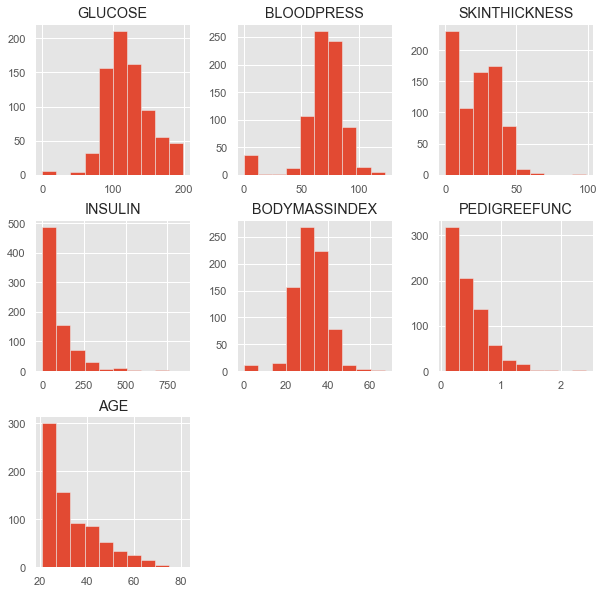

In [5]:
# Continious variables plot. Most of them are skewed. Bodymassindex may be normal (with more data we would be more confident)
df.drop(['PREGNANT', 'DIABETES'], axis=1).hist(figsize=(10,10))
plt.show()

In [6]:
# It can be observed some variables taking 0 value when it is no reasonable. Remove them.
df = df.loc[(df.GLUCOSE > 0) & (df.BLOODPRESS > 0) & (df.BODYMASSINDEX > 0), :]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PREGNANT       724 non-null    int64  
 1   GLUCOSE        724 non-null    int64  
 2   BLOODPRESS     724 non-null    int64  
 3   SKINTHICKNESS  724 non-null    int64  
 4   INSULIN        724 non-null    int64  
 5   BODYMASSINDEX  724 non-null    float64
 6   PEDIGREEFUNC   724 non-null    float64
 7   AGE            724 non-null    int64  
 8   DIABETES       724 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 56.6 KB


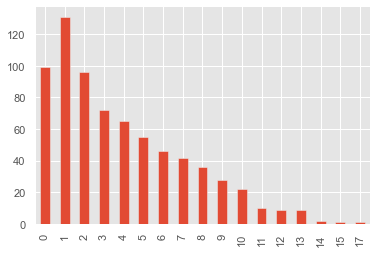

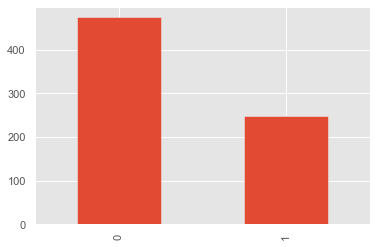

In [7]:
# Discrete variables plot. Pregnant variable is skewed. We can see an unbalance in the diabetes variable.
df['PREGNANT'].value_counts().sort_index().plot.bar()
plt.show()
df['DIABETES'].value_counts().sort_index().plot.bar()
plt.show()

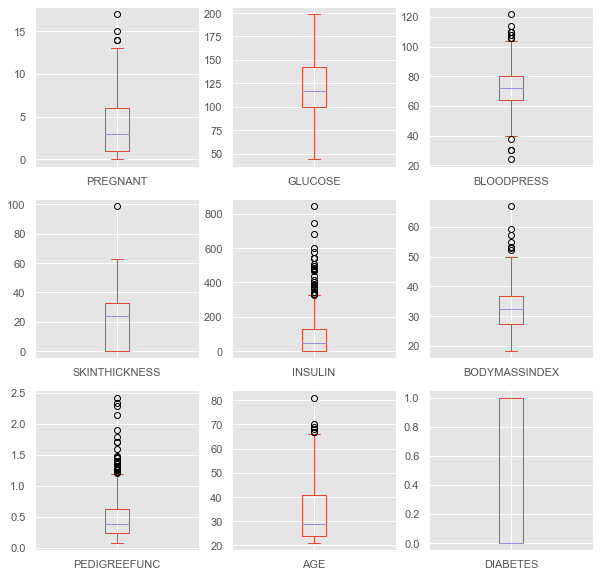

In [8]:
df.plot.box(subplots=True, layout=(3, 3), sharex=False, sharey=False, figsize=(10,10))
plt.show()
# Outliers can be observed (not all of them, this is just a proyection in 1 dimension)

In [9]:
# Encode categorical values
df.DIABETES = df.DIABETES.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   PREGNANT       724 non-null    int64   
 1   GLUCOSE        724 non-null    int64   
 2   BLOODPRESS     724 non-null    int64   
 3   SKINTHICKNESS  724 non-null    int64   
 4   INSULIN        724 non-null    int64   
 5   BODYMASSINDEX  724 non-null    float64 
 6   PEDIGREEFUNC   724 non-null    float64 
 7   AGE            724 non-null    int64   
 8   DIABETES       724 non-null    category
dtypes: category(1), float64(2), int64(6)
memory usage: 51.7 KB


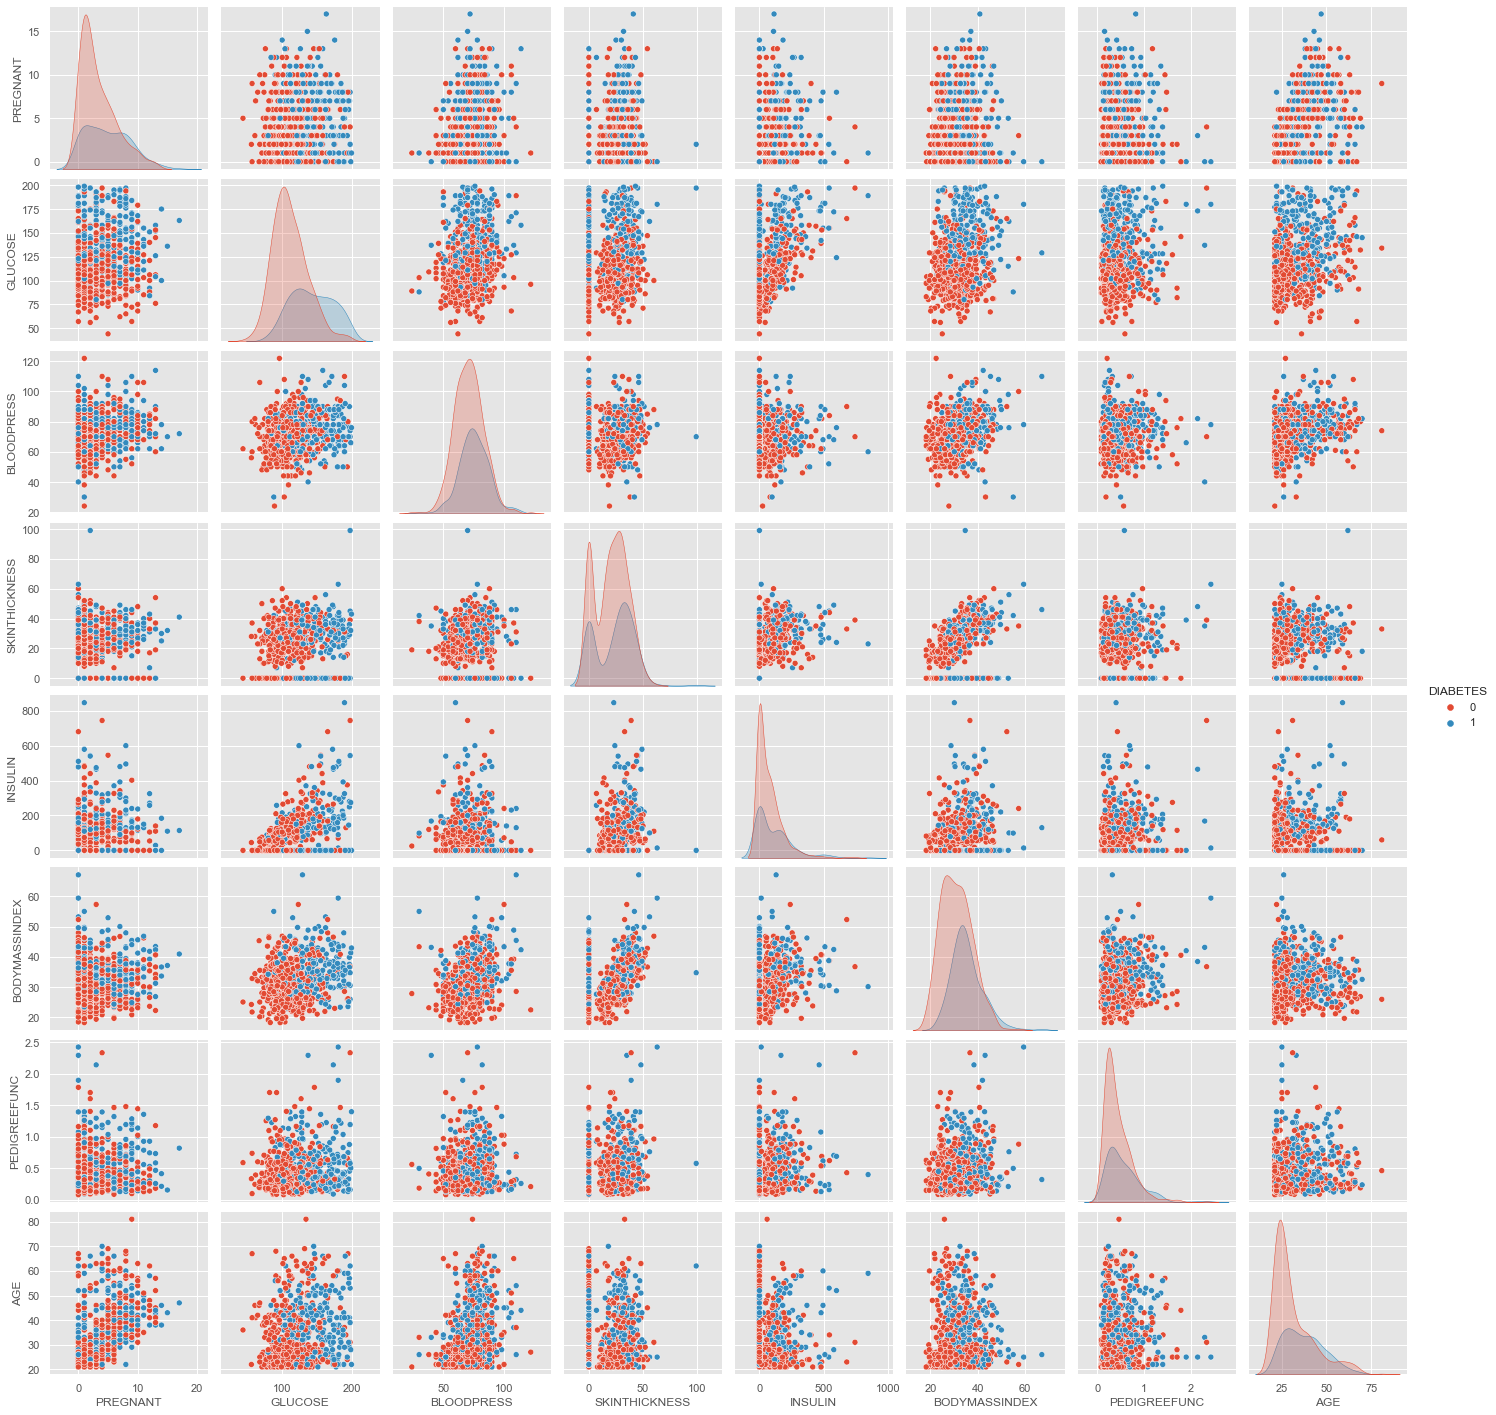

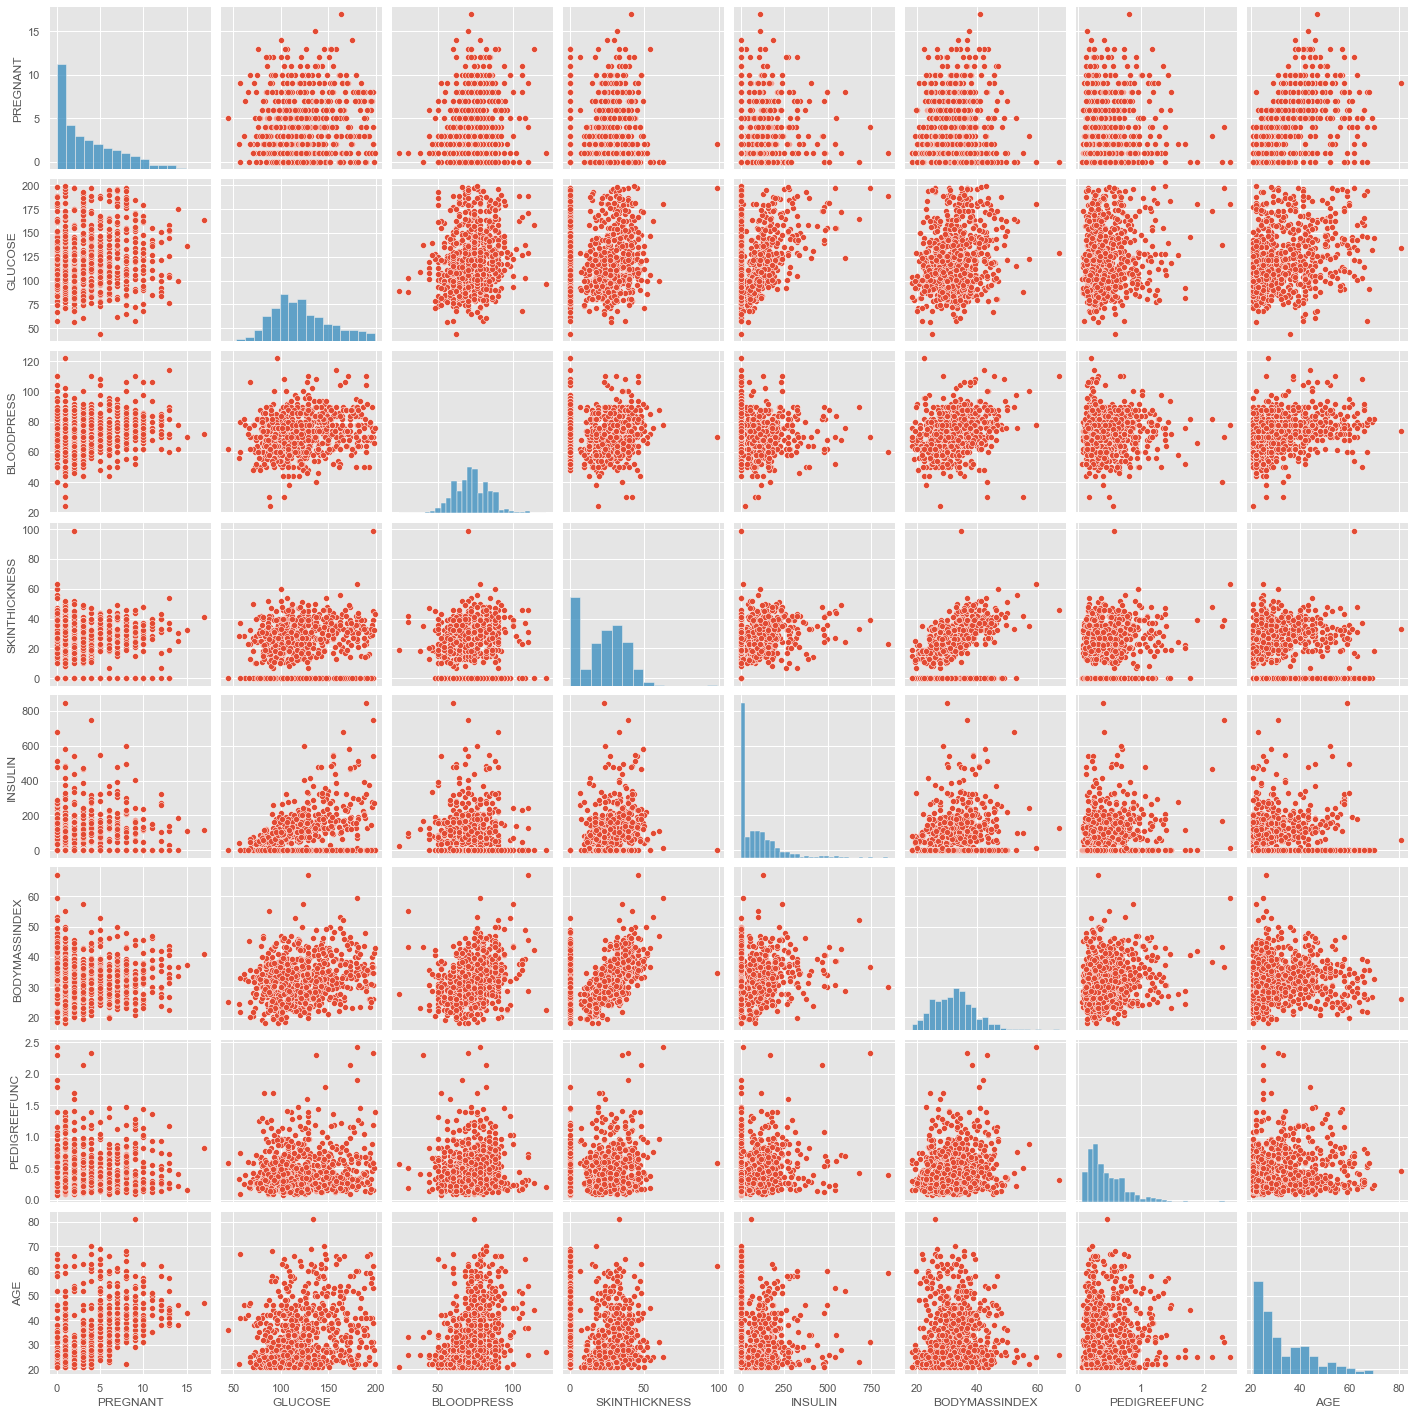

In [10]:
# Analyze continious variables

# Pairplot 
sns.pairplot(df, hue = 'DIABETES')
plt.show()
sns.pairplot(df)
plt.show()
# It can be observed some skewed variables, they can be normalized.

In [11]:
# Data engenieering from the pairplot
# Glucose around 100 in one of the categories
df['DISG'] = (df['GLUCOSE'] - 100) ** 2

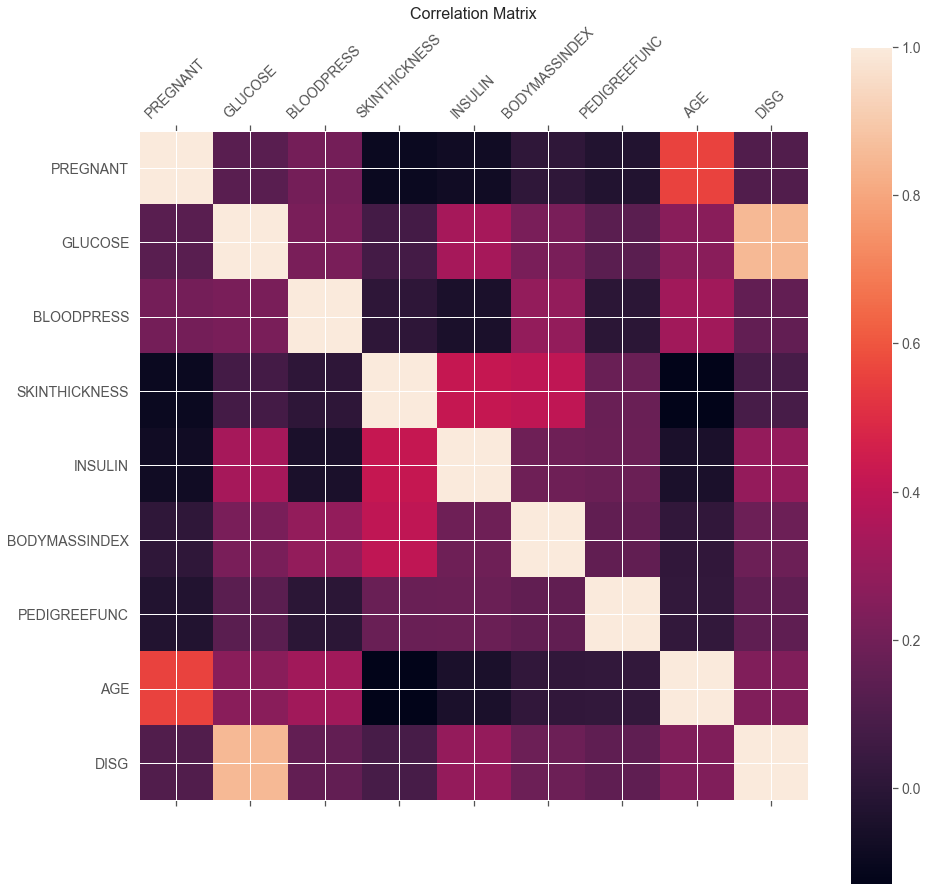

In [12]:
# Correlation plot
#correlation plot of numeric variables
f = plt.figure(figsize=(15,15))
plt.matshow(df.select_dtypes(include=['int64','float64']).corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(include=['int64','float64']).shape[1]), df.select_dtypes(include=['int64','float64']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(include=['int64','float64']).shape[1]), df.select_dtypes(include=['int64','float64']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()
# By looking at the plot, there are no many variables correlated. The ones witch are more correlated are Age, pregnant and DisG, glucose (DisG calculated using glucose)

In [13]:
# Class imbalance
print(df['DIABETES'].value_counts())
# As we can see, class number 0 has double of rows than class number 1 (down-sampling or up-sampling could be used)

# Down-sampling
dw = resample(df.loc[df.DIABETES == 0, :], replace=True, n_samples=400, random_state=2022)

# Up-sampling
up = resample(df.loc[df.DIABETES == 1, :], replace=True, n_samples=400, random_state=2022)

# Balanced dataset
df = pd.concat([dw, up])

df.DIABETES.value_counts()

0    475
1    249
Name: DIABETES, dtype: int64


0    400
1    400
Name: DIABETES, dtype: int64

In [14]:
# Train test split

# Define input and output matrices
INPUTS = list(df.columns)
OUTPUT = 'DIABETES'
INPUTS.remove(OUTPUT)
X = df[INPUTS]
y = df[OUTPUT]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)  

In [15]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Y'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test

 # Logistic Regression

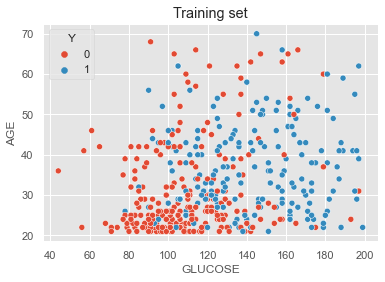

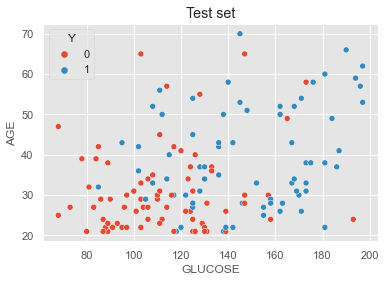

In [16]:
# Plot training and test sets. 
# Plot glucose over age. They follow the same distribution in train and test. 

# Train plot
palette = {0:'C0', 1:'C1'} # Color palette 
sns.scatterplot(x = 'GLUCOSE', y = 'AGE', hue = 'Y', data = dfTR_eval, palette=palette).set_title("Training set")
plt.show()

# Test plot
plt.figure()
sns.scatterplot(x = 'GLUCOSE', y = 'AGE', hue = 'Y', data = dfTS_eval, palette=palette).set_title("Test set")
plt.show()

In [17]:
# Input setting

# Remove this varivable from the numeric input (they will be polynomial)
# Variables selected based on previous logistic regression with all inputs (significance)
NEW_INPUTS = INPUTS.copy()
NEW_INPUTS.remove('BLOODPRESS')
NEW_INPUTS.remove('SKINTHICKNESS')
NEW_INPUTS.remove('AGE')
NEW_INPUTS.remove('GLUCOSE')

# Set diferent types of inputs
INPUTS_LR_NUM =  NEW_INPUTS
INPUTS_LR_SQ = ['AGE', 'GLUCOSE']
INPUTS_LR_CAT = []
INPUTS_LR = INPUTS_LR_NUM + INPUTS_LR_SQ + INPUTS_LR_CAT

# Prepare the numeric variables by scaling
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the quadratic variables by scaling and transforming into a 2 degree polynomial
square_transformer = Pipeline(steps=[('scaler', StandardScaler()),
                                      ('Poly',PolynomialFeatures())])

# Prepare the categorical variables by encoding the categories (No categorical variables)
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_LR_NUM),
        ('sq', square_transformer, INPUTS_LR_SQ),
        ('cat', categorical_transformer, INPUTS_LR_CAT)
        ])

# Create model
LogReg_fit = Pipeline(steps=[('Prep',preprocessor), # Preprocess the variables when training the model 
                        ('LogReg',LogisticRegression(random_state=2022))]) # Model to use in the pipeline
#Train model
LogReg_fit.fit(X_train[INPUTS_LR], y_train)

print("Logistic Regression Trained")

Logistic Regression Trained


In [18]:
# Obtain Cross-Validation accuracy
print("CV accuracy is")
print(cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=10, scoring='accuracy').mean())

CV accuracy is
0.7734375


In [20]:
# Regression summary
CT.summaryLogReg(LogReg_fit, X_train[INPUTS_LR], y_train)
# We can see the estimated values for the variables defined. We can see another measures asociated with them.
# PREGNANT, GLUCOSE, BODYMASSINDEX, PEDIGREEFUNC, AGE and DISG are the most significant variables.  

Deviance Residuals:
        Min        1Q    Median        3Q       Max
0 -0.963251 -0.252555  0.001709  0.245008  0.964574

Coefficients:


LinAlgError: Singular matrix

In [21]:
# Obtain a report of the model based on predictions 
dfTR_eval['Y_LR_pred'] = LogReg_fit.predict(X_train[INPUTS_LR])
dfTR_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,0]
dfTR_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_train[INPUTS_LR])[:,1]
# Scale test using preprocess in training
dfTS_eval['Y_LR_pred'] = LogReg_fit.predict(X_test)
dfTS_eval['Y_LR_prob_neg'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,0]
dfTS_eval['Y_LR_prob_pos'] = LogReg_fit.predict_proba(X_test[INPUTS_LR])[:,1]

#visualize evaluated data
print(dfTR_eval.head())
print(dfTS_eval.head())

     PREGNANT  GLUCOSE  BLOODPRESS  SKINTHICKNESS  INSULIN  BODYMASSINDEX  \
623         0       94          70             27      115           43.5   
602         1      124          74             36        0           27.8   
228         4      197          70             39      744           36.7   
109         0       95          85             25       36           37.4   
59          0      105          64             41      142           41.5   

     PEDIGREEFUNC  AGE  DISG  Y  Y_LR_pred  Y_LR_prob_neg  Y_LR_prob_pos  
623         0.347   21    36  0          0       0.875426       0.124574  
602         0.100   30   576  0          0       0.640806       0.359194  
228         2.329   31  9409  0          1       0.063616       0.936384  
109         0.247   24    25  1          0       0.874987       0.125013  
59          0.173   22    25  0          0       0.819364       0.180636  
     PREGNANT  GLUCOSE  BLOODPRESS  SKINTHICKNESS  INSULIN  BODYMASSINDEX  \
747       

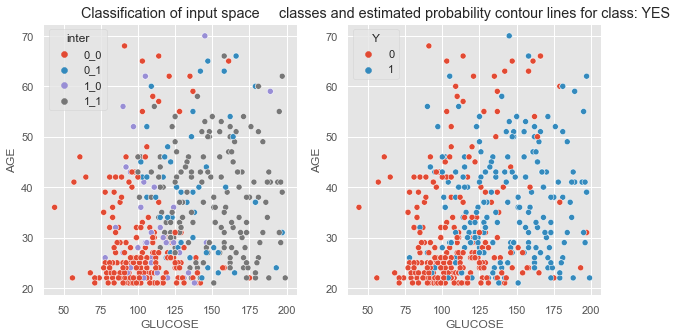

In [22]:
# Plot classification in a 2 dimensional space (Glucose x Age)
plt.figure(figsize=(10, 5))
CT.plot2DClass(X_train[INPUTS_LR], dfTR_eval['Y'], LogReg_fit, 'GLUCOSE', 'AGE', 'YES', 50) 

In [23]:
# Confusion matrix for Log Reg Model
# As a false negative is the worst scenario, we are interested in that measure
print("----- TRAINING CONFUSION MATRIX -----")
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_LR_pred'])
# Accuracy = 0.28 better than the NIR model
# Kappa = 0.56, closer to 1 than 0 (value expected by chance)
# Sensitivity = 0.79, percentage of true values correctly predicted from the real true values
# Specificity = 0.77, percentage of false values correctly predicted from the real false values
# Pos pred value = 0.78, percentage of positives values correctly predicted from the predeicted true values
# Neg pred value = 0.78, percentage of negative values correctly predicted from the predeicted negative values (value we are interested in)
# Detection rate = 0.39, as there are half of each class, best situation is 0.5 and worst 0.
# Prevalence = 0.5 as expected (half of the examples were positive)
# Prevalence close to detection prevalence (total number of true values close to number of true clasifications)
# Balanced accuracy = accuracy (already balanced)
# F Score cercano a 1, mejor valor esperado

----- TRAINING CONFUSION MATRIX -----
Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 247  73
         1  68 252

Accuracy: 0.78
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.56
Mcnemar's Test P-Value: 0.74
Sensitivity: 0.79
Specificity: 0.77
Pos pred value: 0.78
Neg pred value: 0.78
Prevalence: 0.5
Detection Rate: 0.39
Detection prevalence: 0.51
Balanced accuracy: 0.78
F Score: 0.78
Positive class: 1


In [24]:
print("----- TEST CONFUSION MATRIX-----")
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_LR_pred'])

# Values obtained for the test similar or even better than training -> Good generalization

----- TEST CONFUSION MATRIX-----
Confusion Matrix and Statistics
	   Prediction
 Reference  0  1
         0 64 16
         1 12 68

Accuracy: 0.82
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.65
Mcnemar's Test P-Value: 0.57
Sensitivity: 0.85
Specificity: 0.8
Pos pred value: 0.81
Neg pred value: 0.84
Prevalence: 0.5
Detection Rate: 0.42
Detection prevalence: 0.52
Balanced accuracy: 0.82
F Score: 0.83
Positive class: 1


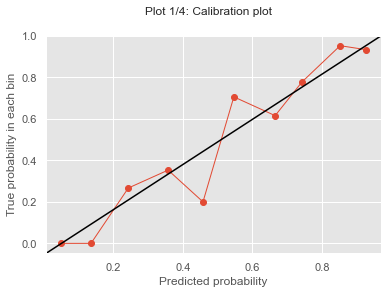

c:\Users\Josed\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Josed\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


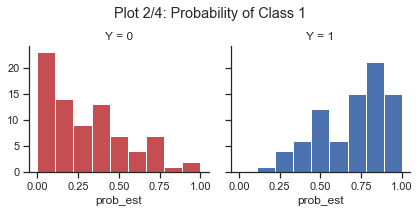

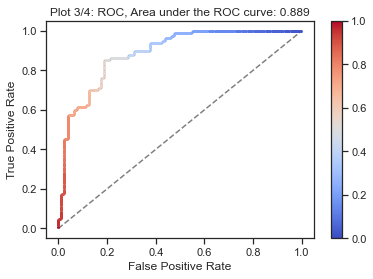

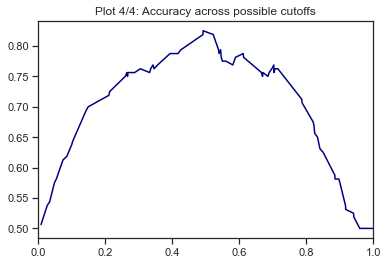

In [25]:
CT.plotClassPerformance(dfTS_eval['Y'], LogReg_fit.predict_proba(X_test[INPUTS_LR]), selClass=1)

# Calibration plot: when we assing probabilities close to 0.4 / 0.6, there are less / more real positive values (around 0.2 / 0.7), they should be close to 0.4 / 0.6.
# Histograms: Probabilities are condensed on the outsides, but we would like to see a more defined tendency 
# AUC: equals to 0.889, close to 1, that means our model performs well with different thresholds
# Accuracy across posible cutoffs plot shows that when the thresholds is close to 0.5 it performs the best

# KNN

In [26]:
# KNN MODEL

# Inputs of the model. Inputs selected based on the LR model information.
INPUTS_KNN = INPUTS.copy()
INPUTS_KNN.remove('BLOODPRESS')
INPUTS_KNN.remove('SKINTHICKNESS')

# Configure model and hyparameter tuning.
param = {'knn__n_neighbors': range(3,135,4)}

# Scale data previous to fit
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined. 
nFolds = 10
knn_fit = GridSearchCV(estimator=pipe, # Model to use
                        param_grid=param, # Grid to search in
                        n_jobs=-1, # Number of cores to use
                        scoring='accuracy', # Accuracy 
                        cv=nFolds) # Number of Folds 

# Search in grid and train model
knn_fit.fit(X_train[INPUTS_KNN], y_train) 

print("KNN Trained")

KNN Trained


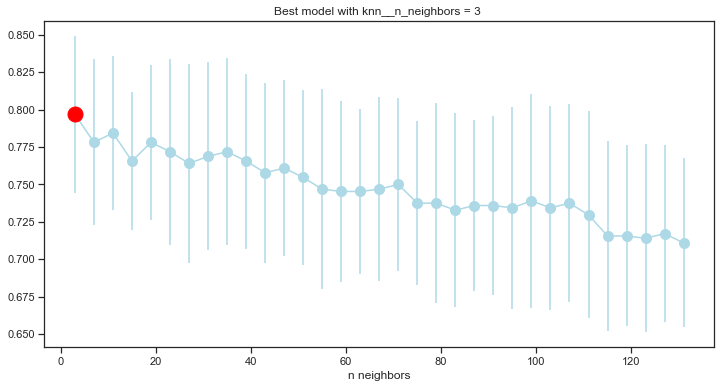

In [27]:
# Scoring plot for each number of neighbors.
# Best model obtained with 3 neighbors (complex model). Greater number of neighbors will lead to a more robust model but a decrease in the score.
MT.plotModelGridError(knn_fit)

In [28]:
# Report of the model based on predictions
dfTR_eval['Y_knn_pred'] = knn_fit.predict(X_train[INPUTS_KNN])
dfTR_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,0]
dfTR_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_train[INPUTS_KNN])[:,1]
# Scale test using preprocess in training
dfTS_eval['Y_knn_pred'] = knn_fit.predict(X_test[INPUTS_KNN])
dfTS_eval['Y_knn_prob_neg'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,0]
dfTS_eval['Y_knn_prob_pos'] = knn_fit.predict_proba(X_test[INPUTS_KNN])[:,1]

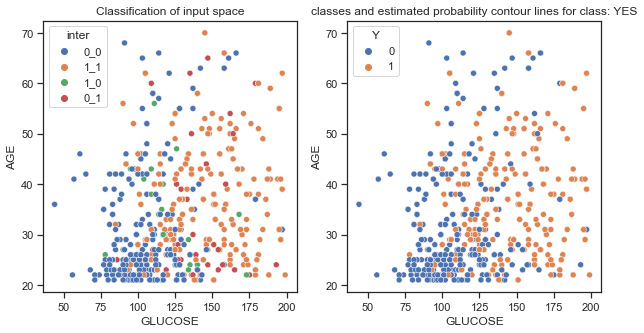

In [29]:
# Plot classification in a 2 dimensional space
plt.figure(figsize=(10, 5))
CT.plot2DClass(X_train[INPUTS_KNN], dfTR_eval['Y'], knn_fit, 'GLUCOSE', 'AGE', 'YES', 50) 

In [30]:
# Confucion matrix for training set
# Again, as a false negative is the worst scenario, we are interested in that measure
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_knn_pred'])
# Accuracy 0.41 superior to the NIR model
# Kappa = 0.82, closer to 1 than 0 (value expected by chance)
# Sensitivity = 0.93, percentage of true values correctly predicted from the real true values
# Specificity = 0.89, percentage of false values correctly predicted from the real false values
# Pos pred value = 0.90, percentage of positives values correctly predicted from the predeicted true values
# Neg pred value = 0.93, percentage of negative values correctly predicted from the predeicted negative values (value we are interested in)
# Prevalence = 0.5 as expected (half of the examples were positive)
# Prevalence close to detection prevalence (total number of true values close to number of true clasifications)
# Detection rate = 0.47, as there are half of each class, best situation is 0.5 and worst 0.
# Balanced accuracy = accuracy (already balanced)
# F score close to 1, best value expected

Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 285  35
         1  21 299

Accuracy: 0.91
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.82
Mcnemar's Test P-Value: 0.08
Sensitivity: 0.93
Specificity: 0.89
Pos pred value: 0.9
Neg pred value: 0.93
Prevalence: 0.5
Detection Rate: 0.47
Detection prevalence: 0.52
Balanced accuracy: 0.91
F Score: 0.91
Positive class: 1


In [31]:
# Confucion matrix for test set
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_knn_pred'])
# All values decreased compared to training set -> Generalitation not as good as LR model 

Confusion Matrix and Statistics
	   Prediction
 Reference  0  1
         0 64 16
         1 14 66

Accuracy: 0.81
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.62
Mcnemar's Test P-Value: 0.86
Sensitivity: 0.82
Specificity: 0.8
Pos pred value: 0.8
Neg pred value: 0.82
Prevalence: 0.5
Detection Rate: 0.41
Detection prevalence: 0.51
Balanced accuracy: 0.81
F Score: 0.81
Positive class: 1


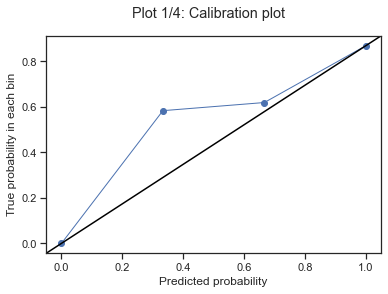

c:\Users\Josed\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Josed\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


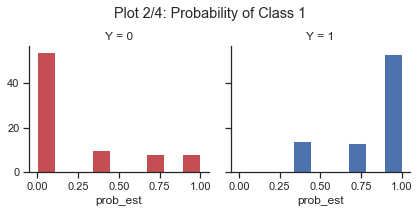

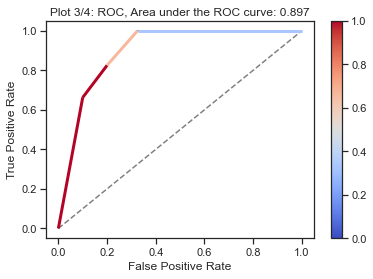

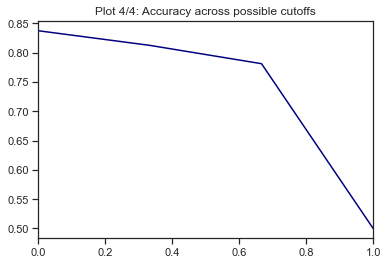

In [32]:
CT.plotClassPerformance(dfTS_eval['Y'], knn_fit.predict_proba(X_test[INPUTS_KNN]), selClass=1)

# Calibration plot: probabilities assigned are close to the true probability for its value except for predicted values around 0.3 where there are more true real values.
# Histograms: Probabilities are condensed on the outsides.
# AUC: equals to 0.897, close to 1, that means our model performs well with different thresholds
# Accuracy across posible cutoffs plot shows that when the thresholds is close to 0 it performs the best. From the value obtained for 0, it can be deduced
# there is a big number of data points with 0 probability.

# Decision Trees

In [35]:
INPUTS_DT = INPUTS

param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('DT', DecisionTreeClassifier(criterion='gini',  # impuriry measure
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                     random_state=2022))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('DT',
                                        DecisionTreeClassifier(min_samples_leaf=5,
                                                               min_samples_split=5,
                                                               random_state=2022))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045])},
             scoring='accuracy')

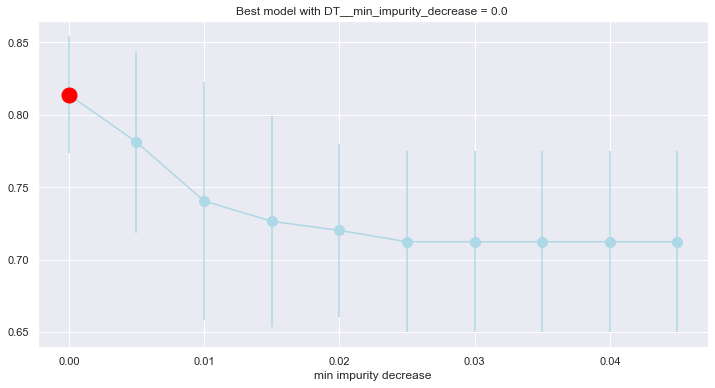

In [36]:
MT.plotModelGridError(tree_fit)

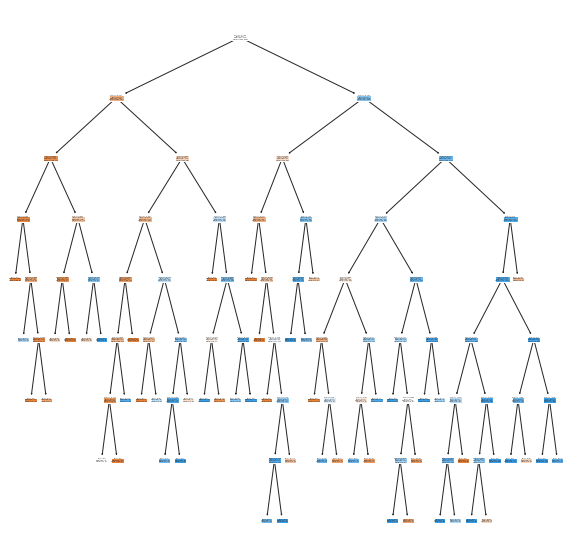

In [37]:
plt.figure(figsize=(10,10))
plot_tree(tree_fit.best_estimator_["DT"], filled=True)
plt.show()

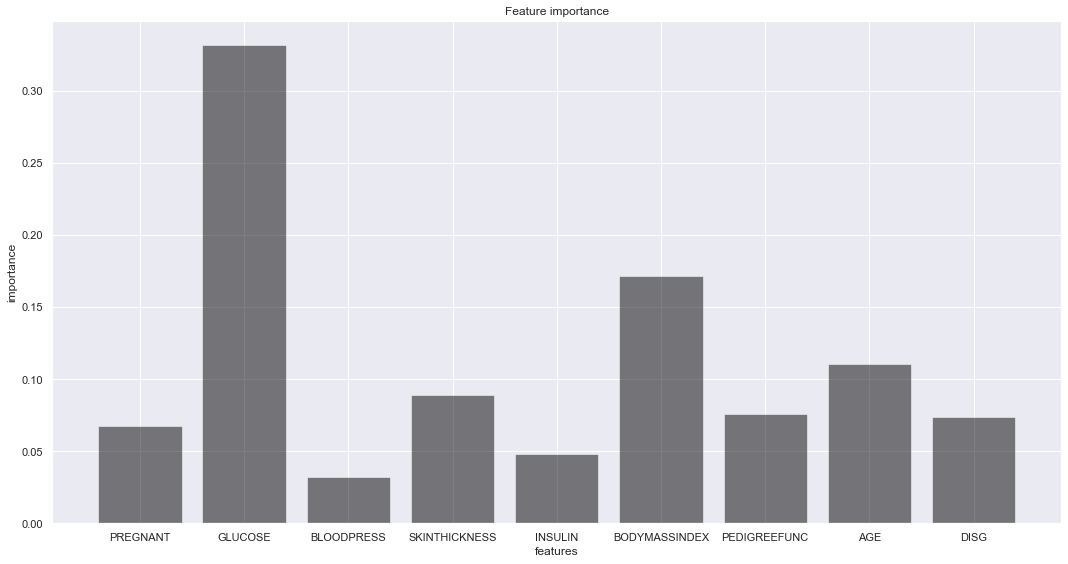

In [38]:
plt.figure(figsize=(15, 8))
index = np.arange(len(X_train[INPUTS_DT].columns))
bar_width = 0.35
plt.bar(index, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train[INPUTS_DT].columns)
plt.tight_layout()
plt.show()

In [39]:
dfTR_eval['Y_DT_pred'] = tree_fit.predict(X_train[INPUTS_DT])
dfTR_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,0]
dfTR_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_train[INPUTS_DT])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_DT_pred'] = tree_fit.predict(X_test[INPUTS_DT])
dfTS_eval['Y_DT_prob_neg'] = tree_fit.predict_proba(X_test[INPUTS_DT])[:,0]
dfTS_eval['Y_DT_prob_pos'] = tree_fit.predict_proba(X_test[INPUTS_DT])[:,1]

#visualize evaluated data
dfTR_eval.head()

PREGNANT  GLUCOSE  BLOODPRESS  SKINTHICKNESS  INSULIN  BODYMASSINDEX  \
623         0       94          70             27      115           43.5   
602         1      124          74             36        0           27.8   
228         4      197          70             39      744           36.7   
109         0       95          85             25       36           37.4   
59          0      105          64             41      142           41.5   

     PEDIGREEFUNC  AGE  DISG  Y  Y_LR_pred  Y_LR_prob_neg  Y_LR_prob_pos  \
623         0.347   21    36  0          0       0.875426       0.124574   
602         0.100   30   576  0          0       0.640806       0.359194   
228         2.329   31  9409  0          1       0.063616       0.936384   
109         0.247   24    25  1          0       0.874987       0.125013   
59          0.173   22    25  0          0       0.819364       0.180636   

     Y_knn_pred  Y_knn_prob_neg  Y_knn_prob_pos  Y_DT_pred  Y_DT_prob_neg  \
623           0        1.000000        0.000000          0       1.000000   
602           0        0.666667        0.333333          0       1.000000   
228           0        1.000000        0.000000          0       0.714286   
109           1        0.333333        0.666667          1       0.375000   
59            0        1.000000        0.000000          0       1.000000   

     Y_DT_prob_pos  
623       0.000000  
602       0.000000  
228       0.285714  
109       0.625000  
59        0.000000

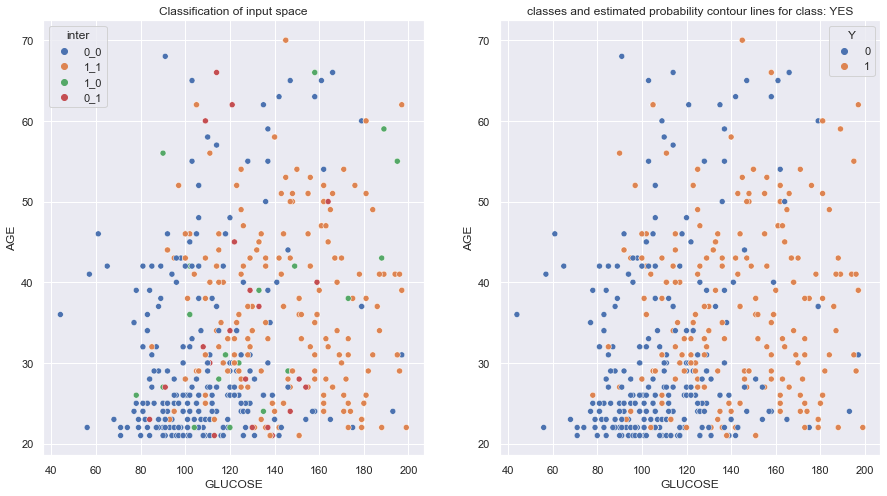

In [40]:
plt.figure(figsize=(15, 8))
CT.plot2DClass(X_train[INPUTS_DT], dfTR_eval['Y'], tree_fit, 'GLUCOSE', 'AGE', 'YES', 50) 

In [41]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_DT_pred'])


Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 299  21
         1  27 293

Accuracy: 0.92
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.85
Mcnemar's Test P-Value: 0.47
Sensitivity: 0.92
Specificity: 0.93
Pos pred value: 0.93
Neg pred value: 0.92
Prevalence: 0.5
Detection Rate: 0.46
Detection prevalence: 0.49
Balanced accuracy: 0.92
F Score: 0.92
Positive class: 1


In [42]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_DT_pred'])

Confusion Matrix and Statistics
	   Prediction
 Reference  0  1
         0 67 13
         1 12 68

Accuracy: 0.84
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.69
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.85
Specificity: 0.84
Pos pred value: 0.84
Neg pred value: 0.85
Prevalence: 0.5
Detection Rate: 0.42
Detection prevalence: 0.51
Balanced accuracy: 0.84
F Score: 0.84
Positive class: 1


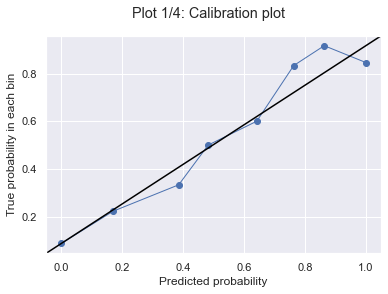

c:\Users\Josed\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Josed\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


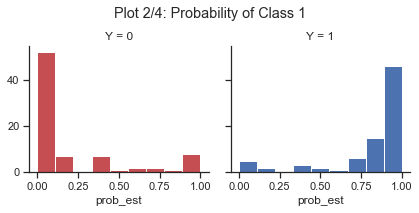

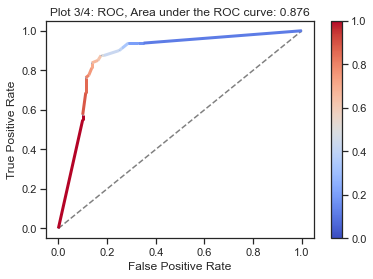

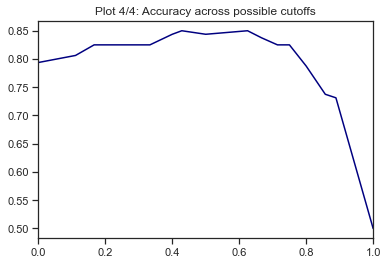

In [43]:
CT.plotClassPerformance(dfTS_eval['Y'], tree_fit.predict_proba(X_test[INPUTS_DT]), selClass=1)

### Modelo entrenado sin las variables que no influyen

In [44]:
del_var= ['PREGNANT','BLOODPRESS', 'INSULIN']
INPUTS_DT_2 = [x for x in INPUTS if x not in del_var]

tree_fit_2 = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
tree_fit_2.fit(X_train[INPUTS_DT_2], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('DT',
                                        DecisionTreeClassifier(min_samples_leaf=5,
                                                               min_samples_split=5,
                                                               random_state=2022))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045])},
             scoring='accuracy')

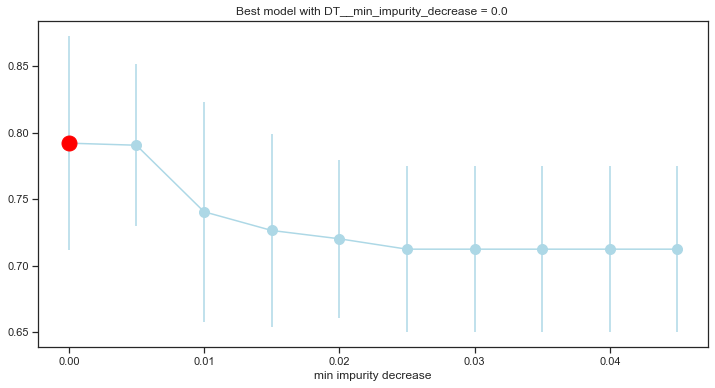

In [45]:
MT.plotModelGridError(tree_fit_2)

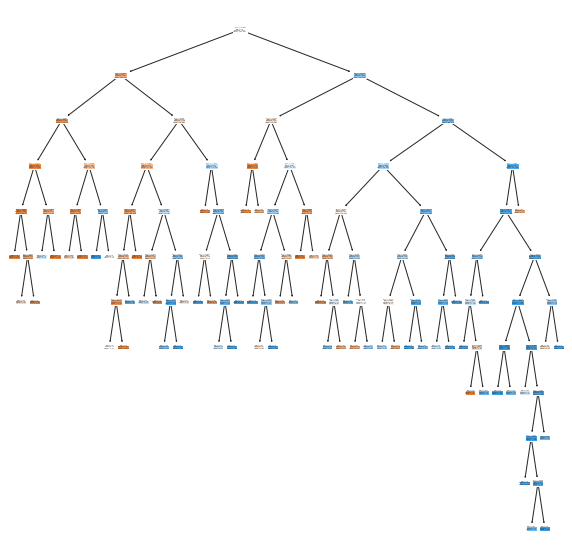

In [46]:
plt.figure(figsize=(10,10))
plot_tree(tree_fit_2.best_estimator_["DT"], filled=True)
plt.show()

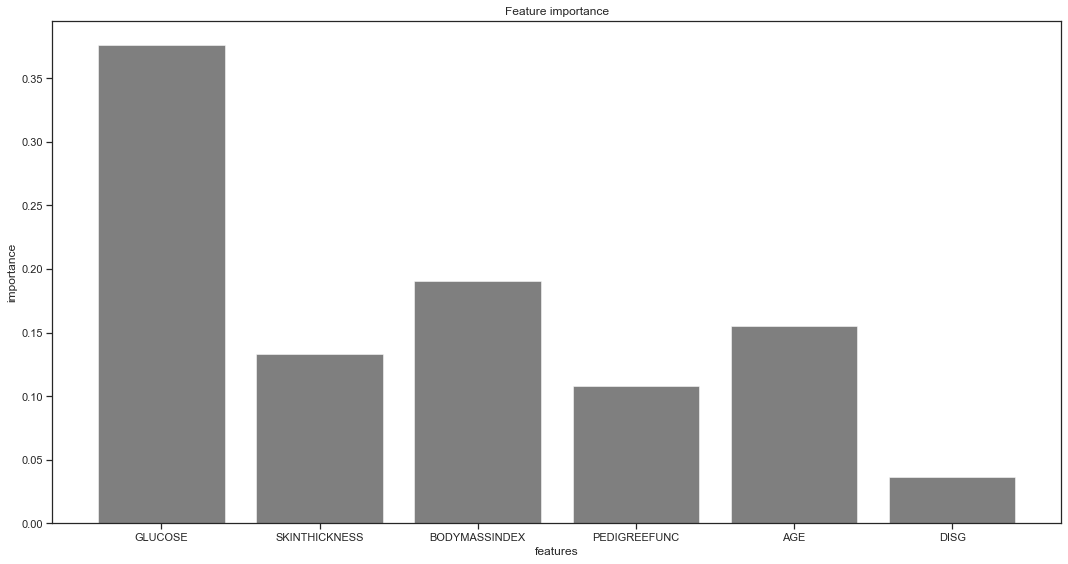

In [47]:
plt.figure(figsize=(15, 8))
index = np.arange(len(X_train[INPUTS_DT_2].columns))
bar_width = 0.35
plt.bar(index, tree_fit_2.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train[INPUTS_DT_2].columns)
plt.tight_layout()
plt.show()

In [48]:
dfTR_eval['Y_DT_2_pred'] = tree_fit_2.predict(X_train[INPUTS_DT_2])
dfTR_eval['Y_DT_2_prob_neg'] = tree_fit_2.predict_proba(X_train[INPUTS_DT_2])[:,0]
dfTR_eval['Y_DT_2_prob_pos'] = tree_fit_2.predict_proba(X_train[INPUTS_DT_2])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_DT_2_pred'] = tree_fit_2.predict(X_test[INPUTS_DT_2])
dfTS_eval['Y_DT_2_prob_neg'] = tree_fit_2.predict_proba(X_test[INPUTS_DT_2])[:,0]
dfTS_eval['Y_DT_2_prob_pos'] = tree_fit_2.predict_proba(X_test[INPUTS_DT_2])[:,1]

#visualize evaluated data
dfTR_eval.head()

PREGNANT  GLUCOSE  BLOODPRESS  SKINTHICKNESS  INSULIN  BODYMASSINDEX  \
623         0       94          70             27      115           43.5   
602         1      124          74             36        0           27.8   
228         4      197          70             39      744           36.7   
109         0       95          85             25       36           37.4   
59          0      105          64             41      142           41.5   

     PEDIGREEFUNC  AGE  DISG  Y  ...  Y_LR_prob_pos  Y_knn_pred  \
623         0.347   21    36  0  ...       0.124574           0   
602         0.100   30   576  0  ...       0.359194           0   
228         2.329   31  9409  0  ...       0.936384           0   
109         0.247   24    25  1  ...       0.125013           1   
59          0.173   22    25  0  ...       0.180636           0   

     Y_knn_prob_neg  Y_knn_prob_pos  Y_DT_pred  Y_DT_prob_neg  Y_DT_prob_pos  \
623        1.000000        0.000000          0       1.000000       0.000000   
602        0.666667        0.333333          0       1.000000       0.000000   
228        1.000000        0.000000          0       0.714286       0.285714   
109        0.333333        0.666667          1       0.375000       0.625000   
59         1.000000        0.000000          0       1.000000       0.000000   

     Y_DT_2_pred  Y_DT_2_prob_neg  Y_DT_2_prob_pos  
623            0         1.000000         0.000000  
602            0         0.888889         0.111111  
228            0         0.800000         0.200000  
109            0         0.600000         0.400000  
59             0         1.000000         0.000000  

[5 rows x 22 columns]

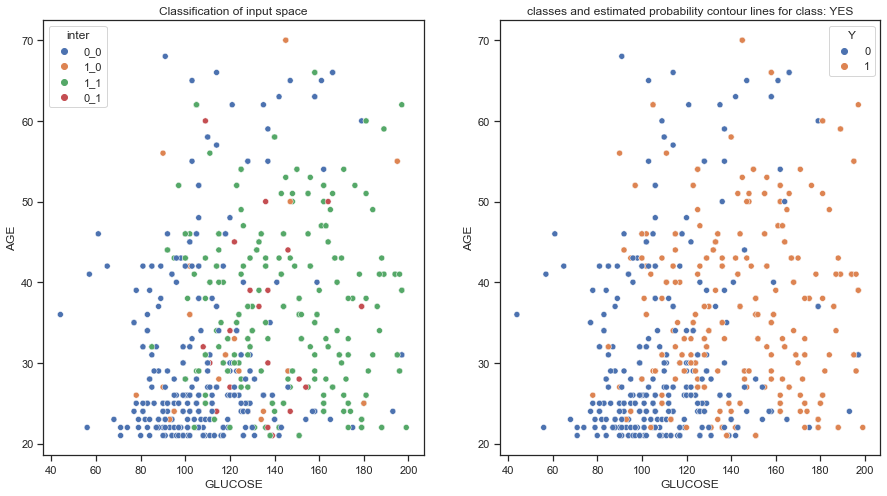

In [49]:
plt.figure(figsize=(15, 8))
CT.plot2DClass(X_train[INPUTS_DT_2], dfTR_eval['Y'], tree_fit_2, 'GLUCOSE', 'AGE', 'YES', 50) 

In [50]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_DT_2_pred'])


Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 293  27
         1  28 292

Accuracy: 0.91
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.83
Mcnemar's Test P-Value: 1.0
Sensitivity: 0.91
Specificity: 0.92
Pos pred value: 0.92
Neg pred value: 0.91
Prevalence: 0.5
Detection Rate: 0.46
Detection prevalence: 0.5
Balanced accuracy: 0.91
F Score: 0.91
Positive class: 1


In [51]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_DT_2_pred'])

Confusion Matrix and Statistics
	   Prediction
 Reference  0  1
         0 66 14
         1  8 72

Accuracy: 0.86
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.72
Mcnemar's Test P-Value: 0.29
Sensitivity: 0.9
Specificity: 0.82
Pos pred value: 0.84
Neg pred value: 0.89
Prevalence: 0.5
Detection Rate: 0.45
Detection prevalence: 0.54
Balanced accuracy: 0.86
F Score: 0.87
Positive class: 1


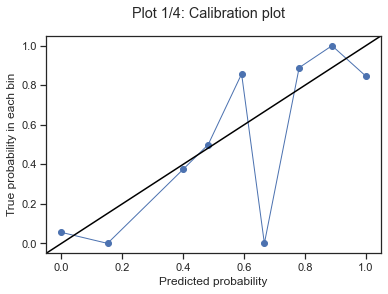

c:\Users\Josed\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Josed\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


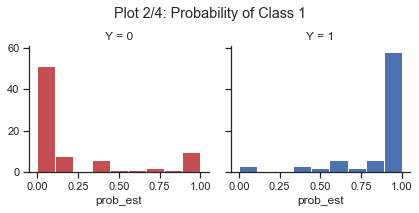

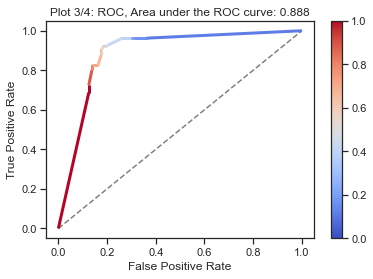

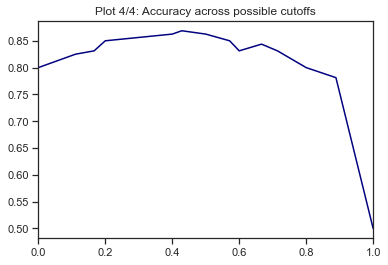

In [52]:
CT.plotClassPerformance(dfTS_eval['Y'], tree_fit_2.predict_proba(X_test[INPUTS_DT_2]), selClass=1)

# SVM

In [53]:
# Radial SVM MODEL

# Inputs of the model. Inputs selected based on the LR model information.
INPUTS_RSVC = INPUTS.copy()
INPUTS_RSVC.remove('BLOODPRESS')
INPUTS_RSVC.remove('SKINTHICKNESS')

# Train model
param = {'SVC__C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000], # Cost term
         'SVC__gamma':[0.0001,0.001,0.01,0.1,1,10]} # Inverse width parameter in the Gaussian Radial Basis kernel 

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('SVC', SVC(kernel='rbf', # gaussian kernel (data not linearly separable)
                                   probability=True, # let the model predict probabilities
                                   random_state=150))]) # For replication

# Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
SVC_fit = GridSearchCV(estimator=pipe, # Structure of the model
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use
                       scoring='accuracy', # Accuracy
                       cv=nFolds) # Number of Folds 
SVC_fit.fit(X_train[INPUTS_RSVC], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVC',
                                        SVC(probability=True,
                                            random_state=150))]),
             n_jobs=-1,
             param_grid={'SVC__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                    1000],
                         'SVC__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring='accuracy')

In [54]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(SVC_fit, X_train[INPUTS_RSVC], y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.8609375

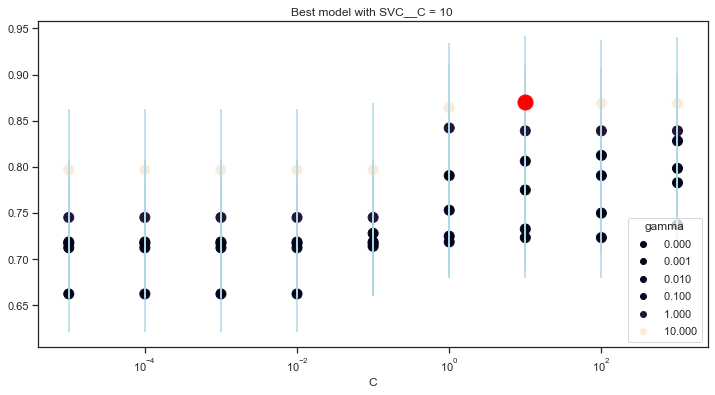

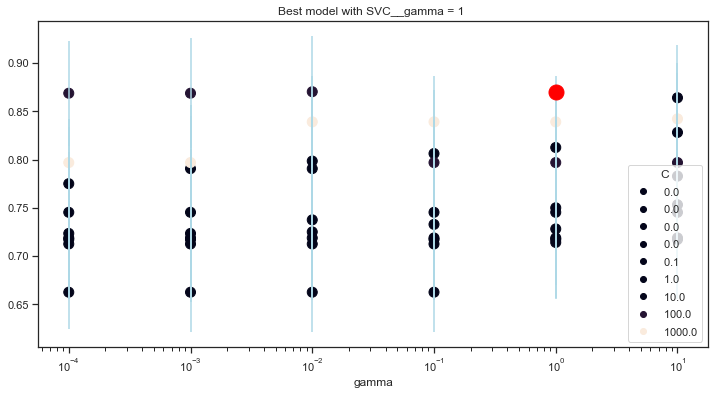

In [55]:
MT.plotModelGridError(SVC_fit, xscale="log", xscale2='log')
# Best model with cost = 10 and gamma = 1

In [56]:
# Report of the model based on predictions
dfTR_eval['Y_SVC_pred'] = SVC_fit.predict(X_train[INPUTS_RSVC])
dfTR_eval['Y_SVC_prob_neg'] = SVC_fit.predict_proba(X_train[INPUTS_RSVC])[:,0]
dfTR_eval['Y_SVC_prob_pos'] = SVC_fit.predict_proba(X_train[INPUTS_RSVC])[:,1]
#Scale test using preprocess in training
dfTS_eval['Y_SVC_pred'] = SVC_fit.predict(X_test[INPUTS_RSVC])
dfTS_eval['Y_SVC_prob_neg'] = SVC_fit.predict_proba(X_test[INPUTS_RSVC])[:,0]
dfTS_eval['Y_SVC_prob_pos'] = SVC_fit.predict_proba(X_test[INPUTS_RSVC])[:,1]

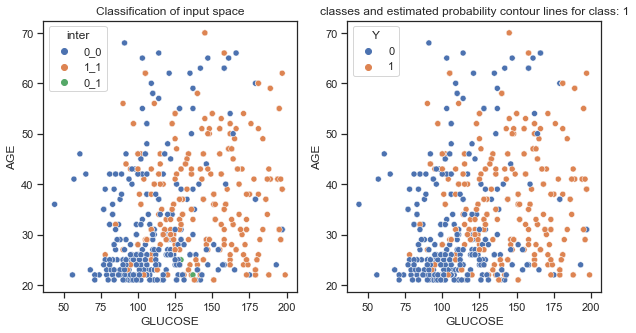

In [57]:
# Plot classification in a 2 dimensional space
plt.figure(figsize=(10, 5))
CT.plot2DClass(X_train[INPUTS_RSVC], dfTR_eval['Y'], SVC_fit, 'GLUCOSE', 'AGE', 1, 50) 

In [58]:
# Train confusion matrix
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_SVC_pred'])
# Accuracy 0.50 superior to the NIR model
# Kappa = 0.99, closer to 1 than 0 (value expected by chance)
# Sensitivity = 1, percentage of true values correctly predicted from the real true values
# Specificity = 0.99, percentage of false values correctly predicted from the real false values
# Pos pred value = 0.99, percentage of positives values correctly predicted from the predeicted true values
# Neg pred value = 1, percentage of negative values correctly predicted from the predeicted negative values (value we are interested in)
# Prevalence = 0.5 as expected (half of the examples were positive)
# Prevalence close to detection prevalence (total number of true values close to number of true clasifications)
# Detection rate = 0.50, as there are half of each class, best situation is 0.5 and worst 0.
# Balanced accuracy = accuracy (already balanced)
# F score equals 1, best value expected
# It is clear the model is overfitted. Changing the hyperparameters (reducing its values) could lead to a less complex and most robust model.

Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 318   2
         1   0 320

Accuracy: 1.0
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.99
Mcnemar's Test P-Value: 0.5
Sensitivity: 1.0
Specificity: 0.99
Pos pred value: 0.99
Neg pred value: 1.0
Prevalence: 0.5
Detection Rate: 0.5
Detection prevalence: 0.5
Balanced accuracy: 1.0
F Score: 1.0
Positive class: 1


In [59]:
# Test confusion matrix
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_SVC_pred'])

# Values obtained decrease in comparation to the training as expected (overfitting). Nevertheless, test measures obtained are really good.

Confusion Matrix and Statistics
	   Prediction
 Reference  0  1
         0 70 10
         1  4 76

Accuracy: 0.91
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.82
Mcnemar's Test P-Value: 0.18
Sensitivity: 0.95
Specificity: 0.88
Pos pred value: 0.88
Neg pred value: 0.95
Prevalence: 0.5
Detection Rate: 0.48
Detection prevalence: 0.54
Balanced accuracy: 0.91
F Score: 0.92
Positive class: 1


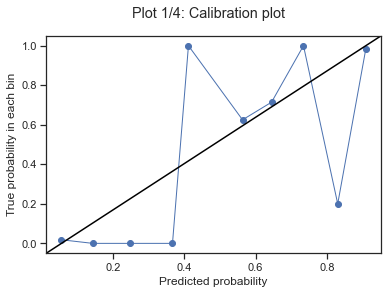

c:\Users\Josed\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Josed\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


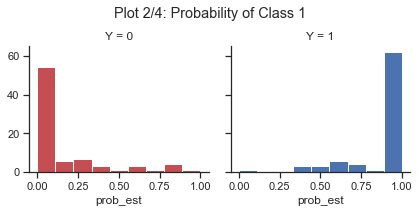

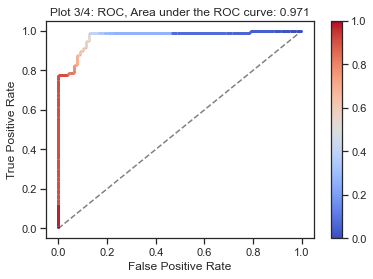

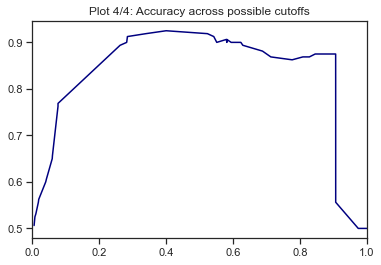

In [60]:
CT.plotClassPerformance(dfTS_eval['Y'], SVC_fit.predict_proba(X_test[INPUTS_RSVC]), selClass=1)
# Calibration plot: probabilities assigned are not close to the true probability for its value
# Histograms: Probabilities are condensed on the outsides.
# AUC: equals to 0.971, close to 1, that means our model performs well with different thresholds
# Accuracy across posible cutoffs plot shows that when the thresholds is close to 0.4 it performs the best. It performs well for any value in [0.2, 0.9]

# MLP

In [61]:
# MLP Class MODEL 
# Inputs of the model. Inputs selected based on the LR model information.
INPUTS_MLP = INPUTS.copy()
INPUTS_MLP.remove('BLOODPRESS')
INPUTS_MLP.remove('SKINTHICKNESS')

# After using different configurations (solver, activation function, MLP architecture) this is the best we have found:
param = {'MLP__alpha': [0.001], # L2 regularization term 
         'MLP__hidden_layer_sizes':[(20,10,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('MLP', MLPClassifier(solver='lbfgs', # Update function (optimization)
                                             activation='logistic', # Logistic sigmoid activation function (hidden)
                                             max_iter=450, # Maximum number of iterations
                                             tol=1e-4, # Tolerance for the optimization
                                             random_state=150,
                                             verbose = True))]) # For replication

# Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use
                       scoring='accuracy', # Accuracy
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('MLP',
                                        MLPClassifier(activation='logistic',
                                                      max_iter=450,
                                                      random_state=150,
                                                      solver='lbfgs',
                                                      verbose=True))]),
             n_jobs=-1,
             param_grid={'MLP__alpha': [0.001],
                         'MLP__hidden_layer_sizes': [(20, 10)]},
             scoring='accuracy')

In [62]:
# MT.plotModelGridError(MLP_fit, xscale2="log")

In [63]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['scaler'].transform(X_train[INPUTS_MLP])
X = pd.DataFrame(X, columns=X_train[INPUTS_MLP].columns)
y = pd.DataFrame(y_train, columns=X_train[INPUTS_MLP].columns)
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [64]:
# sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X[INPUTS_MLP], y, use_torch=False)
# print(sensmlp.summary())
# print(sensmlp.info())
# print(sensmlp.plot())

# From previous runs, it can be seen that AGE, INSULIN and PREGNANT are the ones with less sensitivity

In [65]:
# Report of the model based on predictions
dfTR_eval['Y_MLP_pred'] = MLP_fit.predict(X_train[INPUTS_MLP])
dfTR_eval['Y_MLP_prob_neg'] = MLP_fit.predict_proba(X_train[INPUTS_MLP])[:,0]
dfTR_eval['Y_MLP_prob_pos'] = MLP_fit.predict_proba(X_train[INPUTS_MLP])[:,1]
# Scale test using preprocess in training
dfTS_eval['Y_MLP_pred'] = MLP_fit.predict(X_test[INPUTS_MLP])
dfTS_eval['Y_MLP_prob_neg'] = MLP_fit.predict_proba(X_test[INPUTS_MLP])[:,0]
dfTS_eval['Y_MLP_prob_pos'] = MLP_fit.predict_proba(X_test[INPUTS_MLP])[:,1]

# Visualize evaluated data
dfTR_eval.head()

PREGNANT  GLUCOSE  BLOODPRESS  SKINTHICKNESS  INSULIN  BODYMASSINDEX  \
623         0       94          70             27      115           43.5   
602         1      124          74             36        0           27.8   
228         4      197          70             39      744           36.7   
109         0       95          85             25       36           37.4   
59          0      105          64             41      142           41.5   

     PEDIGREEFUNC  AGE  DISG  Y  ...  Y_DT_prob_pos  Y_DT_2_pred  \
623         0.347   21    36  0  ...       0.000000            0   
602         0.100   30   576  0  ...       0.000000            0   
228         2.329   31  9409  0  ...       0.285714            0   
109         0.247   24    25  1  ...       0.625000            0   
59          0.173   22    25  0  ...       0.000000            0   

     Y_DT_2_prob_neg  Y_DT_2_prob_pos  Y_SVC_pred  Y_SVC_prob_neg  \
623         1.000000         0.000000           0        0.957025   
602         0.888889         0.111111           0        0.922912   
228         0.800000         0.200000           0        0.922883   
109         0.600000         0.400000           1        0.184701   
59          1.000000         0.000000           0        0.963843   

     Y_SVC_prob_pos  Y_MLP_pred  Y_MLP_prob_neg  Y_MLP_prob_pos  
623        0.042975           0        1.000000    1.214322e-09  
602        0.077088           0        0.999571    4.288955e-04  
228        0.077117           0        0.999758    2.421140e-04  
109        0.815299           1        0.000101    9.998988e-01  
59         0.036157           0        1.000000    7.147360e-08  

[5 rows x 28 columns]

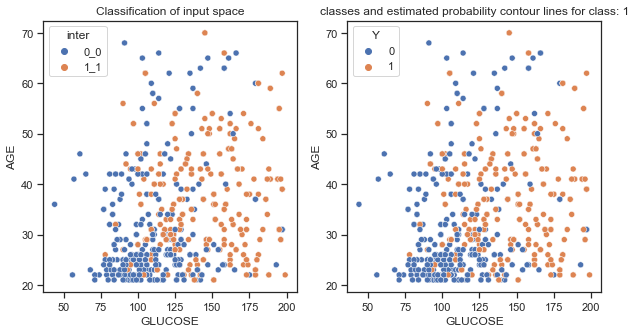

In [66]:
# Plot classification in a 2 dimensional space
plt.figure(figsize=(10,5))
CT.plot2DClass(X_train[INPUTS_MLP], dfTR_eval['Y'], MLP_fit, 'GLUCOSE', 'AGE', 1, np_grid=50) 

# From what we have seen in the confusion matrix, a complex model is expected to be seen in the plot.

In [67]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_MLP_pred'], labels=[1,0])
# Accuracy 0.50 superior to the NIR model
# Kappa = 1, closer to 1 than 0 (value expected by chance)
# Sensitivity = 1, percentage of true values correctly predicted from the real true values
# Specificity = 1, percentage of false values correctly predicted from the real false values
# Pos pred value = 1, percentage of positives values correctly predicted from the predeicted true values
# Neg pred value = 1, percentage of negative values correctly predicted from the predeicted negative values (value we are interested in)
# Prevalence = 0.5 as expected (half of the examples were positive)
# Prevalence close to detection prevalence (total number of true values close to number of true clasifications)
# Detection rate = 0.50, as there are half of each class, best situation is 0.5 and worst 0.
# Balanced accuracy = accuracy (already balanced)
# F score equals 1, best value expected
# It is clear the model is overfitted. Changing the hyperparameters (reducing number of perceptorns and increasing alpha) could lead to a less complex and most robust model.

Confusion Matrix and Statistics
	   Prediction
 Reference   1   0
         1 320   0
         0   0 320

Accuracy: 1.0
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Pos pred value: 1.0
Neg pred value: 1.0
Prevalence: 0.5
Detection Rate: 0.5
Detection prevalence: 0.5
Balanced accuracy: 1.0
F Score: 1.0
Positive class: 0


In [68]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_MLP_pred'], labels=[1,0])
# Values obtained decrease in comparation to the training as expected (overfitting). Nevertheless, test measures obtained are really good.

Confusion Matrix and Statistics
	   Prediction
 Reference  1  0
         1 74  6
         0 11 69

Accuracy: 0.89
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.79
Mcnemar's Test P-Value: 0.33
Sensitivity: 0.86
Specificity: 0.92
Pos pred value: 0.92
Neg pred value: 0.87
Prevalence: 0.5
Detection Rate: 0.43
Detection prevalence: 0.47
Balanced accuracy: 0.89
F Score: 0.89
Positive class: 0


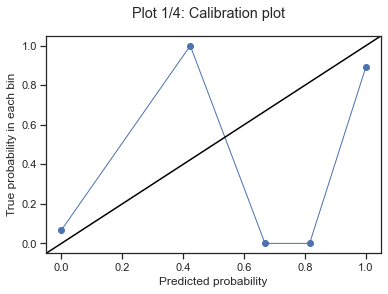

c:\Users\Josed\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Josed\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


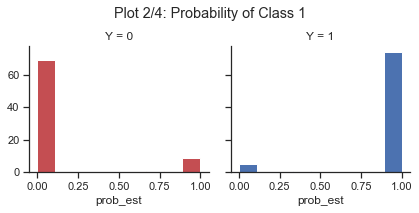

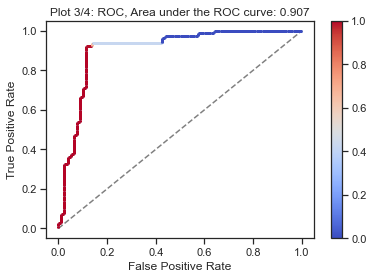

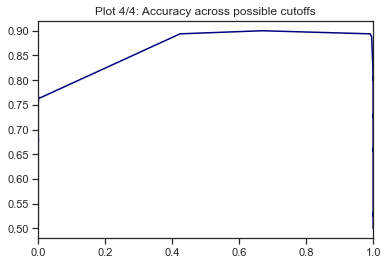

In [69]:
CT.plotClassPerformance(dfTS_eval['Y'], MLP_fit.predict_proba(X_test[INPUTS_MLP]), selClass=1)
# Calibration plot: probabilities assigned are not close to the true probability for its value
# Histograms: Probabilities are condensed on the outsides.
# AUC: equals to 0.923, close to 1, that means our model performs well with different thresholds
# Accuracy across posible cutoffs plot shows that the model performs well for any value in [0, 1]

# Gradient Boosting

So the extra model we are going to create is based on Gradient Boosting. This method is included in the family of the ensembles, in which we can find methods like this one or Random Forest. This kind of models are, like the word says, an ensemble of simple models in order to create a more powerful model. 

In [70]:
INPUTS_GB = INPUTS.copy()

param = {'GB__learning_rate': [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]}
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('GB', GradientBoostingClassifier(
                                                     min_samples_split=5, # Minimum number of obs in node to keep cutting
                                                     min_samples_leaf=5, # Minimum number of obs in a terminal node
                                                     random_state=2022))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
gb_clf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
gb_clf_fit.fit(X_train[INPUTS_GB], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('GB',
                                        GradientBoostingClassifier(min_samples_leaf=5,
                                                                   min_samples_split=5,
                                                                   random_state=2022))]),
             n_jobs=-1,
             param_grid={'GB__learning_rate': [0.05, 0.075, 0.1, 0.25, 0.5,
                                               0.75, 1]},
             scoring='accuracy')

So the hyperparameter we have tuned is the "learning rate" in order to control the speed in which the model improves its results. We have chosen this values to see how the model will react to quick and slow learning rate.

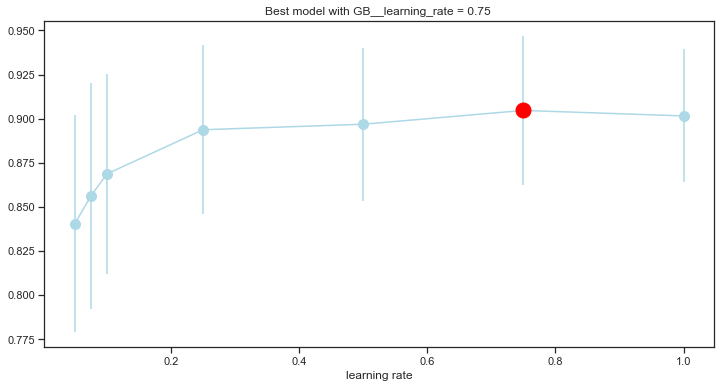

In [71]:
MT.plotModelGridError(gb_clf_fit)

After evaluating the different models, we can see that the best results are obtained with learning rate = 0.75 with an AUC = 0.902 

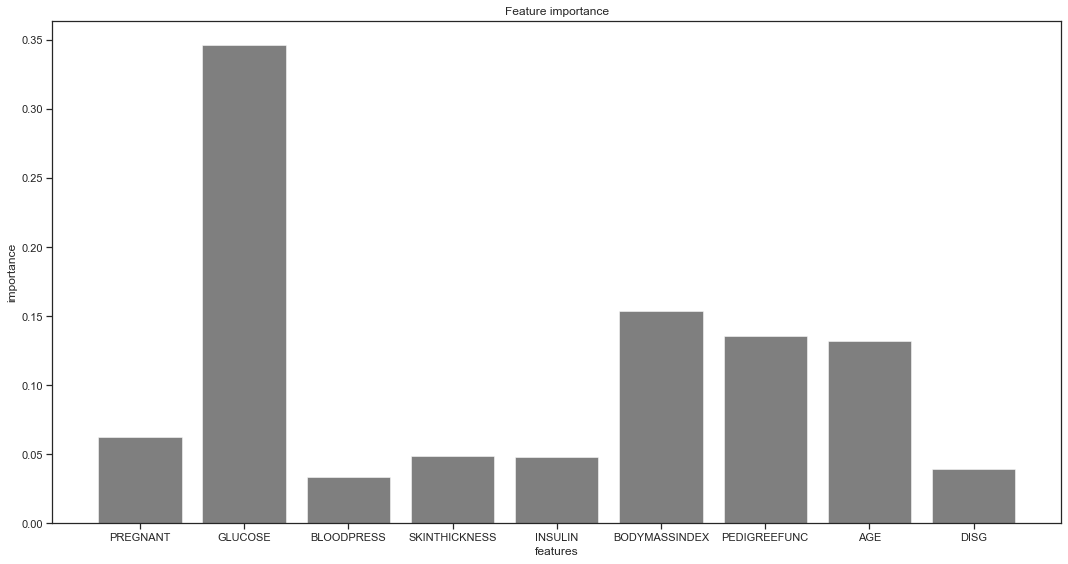

In [72]:
plt.figure(figsize=(15, 8))
index = np.arange(len(X_train[INPUTS_GB].columns))
bar_width = 0.35
plt.bar(index, gb_clf_fit.best_estimator_['GB'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Feature importance')
plt.xticks(index, X_train[INPUTS_GB].columns)
plt.tight_layout()
plt.show()

In [73]:
dfTR_eval['Y_GB_pred'] = gb_clf_fit.predict(X_train[INPUTS_GB])
dfTR_eval['Y_GB_prob_neg'] = gb_clf_fit.predict_proba(X_train[INPUTS_GB])[:,0]
dfTR_eval['Y_GB_prob_pos'] = gb_clf_fit.predict_proba(X_train[INPUTS_GB])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_GB_pred'] = gb_clf_fit.predict(X_test[INPUTS_GB])
dfTS_eval['Y_GB_prob_neg'] = gb_clf_fit.predict_proba(X_test[INPUTS_GB])[:,0]
dfTS_eval['Y_GB_prob_pos'] = gb_clf_fit.predict_proba(X_test[INPUTS_GB])[:,1]

#visualize evaluated data
dfTR_eval.head()

PREGNANT  GLUCOSE  BLOODPRESS  SKINTHICKNESS  INSULIN  BODYMASSINDEX  \
623         0       94          70             27      115           43.5   
602         1      124          74             36        0           27.8   
228         4      197          70             39      744           36.7   
109         0       95          85             25       36           37.4   
59          0      105          64             41      142           41.5   

     PEDIGREEFUNC  AGE  DISG  Y  ...  Y_DT_2_prob_pos  Y_SVC_pred  \
623         0.347   21    36  0  ...         0.000000           0   
602         0.100   30   576  0  ...         0.111111           0   
228         2.329   31  9409  0  ...         0.200000           0   
109         0.247   24    25  1  ...         0.400000           1   
59          0.173   22    25  0  ...         0.000000           0   

     Y_SVC_prob_neg  Y_SVC_prob_pos  Y_MLP_pred  Y_MLP_prob_neg  \
623        0.957025        0.042975           0        1.000000   
602        0.922912        0.077088           0        0.999571   
228        0.922883        0.077117           0        0.999758   
109        0.184701        0.815299           1        0.000101   
59         0.963843        0.036157           0        1.000000   

     Y_MLP_prob_pos  Y_GB_pred  Y_GB_prob_neg  Y_GB_prob_pos  
623    1.214322e-09          0       0.999117       0.000883  
602    4.288955e-04          0       0.998648       0.001352  
228    2.421140e-04          0       0.998015       0.001985  
109    9.998988e-01          1       0.010527       0.989473  
59     7.147360e-08          0       0.999848       0.000152  

[5 rows x 31 columns]

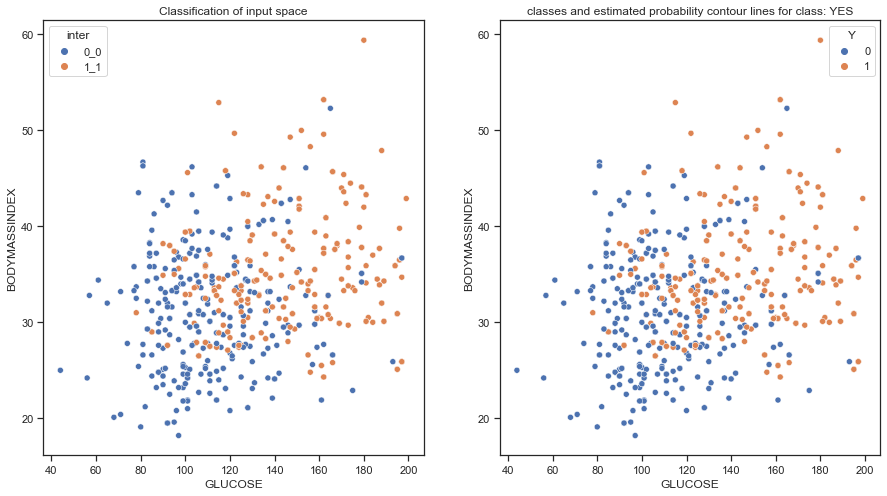

In [74]:
plt.figure(figsize=(15, 8))
CT.plot2DClass(X_train[INPUTS_GB], dfTR_eval['Y'], gb_clf_fit, 'GLUCOSE', 'BODYMASSINDEX', 'YES', 50) 

In [75]:
CT.confusion_matrix(dfTR_eval['Y'], dfTR_eval['Y_GB_pred'])


Confusion Matrix and Statistics
	   Prediction
 Reference   0   1
         0 320   0
         1   0 320

Accuracy: 1.0
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 1.0
Mcnemar's Test P-Value: 1.0
Sensitivity: 1.0
Specificity: 1.0
Pos pred value: 1.0
Neg pred value: 1.0
Prevalence: 0.5
Detection Rate: 0.5
Detection prevalence: 0.5
Balanced accuracy: 1.0
F Score: 1.0
Positive class: 1


In [76]:
CT.confusion_matrix(dfTS_eval['Y'], dfTS_eval['Y_GB_pred'])

Confusion Matrix and Statistics
	   Prediction
 Reference  0  1
         0 66 14
         1  7 73

Accuracy: 0.87
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.74
Mcnemar's Test P-Value: 0.19
Sensitivity: 0.91
Specificity: 0.82
Pos pred value: 0.84
Neg pred value: 0.9
Prevalence: 0.5
Detection Rate: 0.46
Detection prevalence: 0.54
Balanced accuracy: 0.87
F Score: 0.87
Positive class: 1


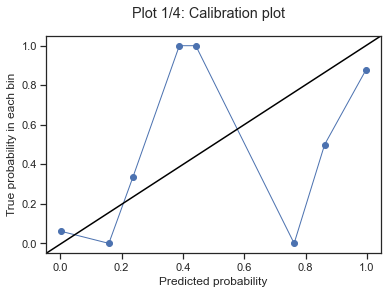

c:\Users\Josed\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
c:\Users\Josed\anaconda3\envs\ml\lib\site-packages\seaborn\axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


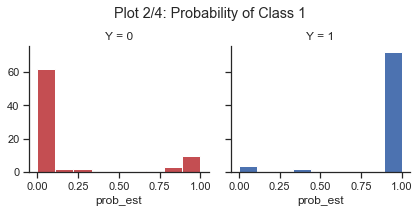

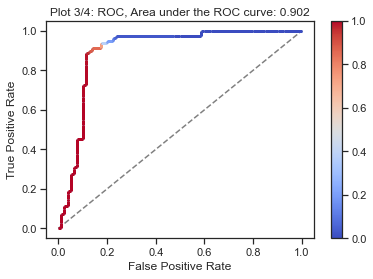

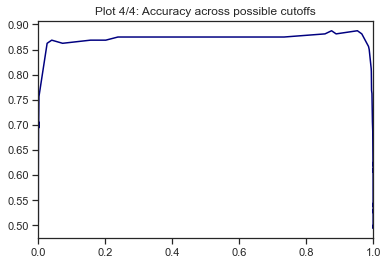

In [77]:
CT.plotClassPerformance(dfTS_eval['Y'], gb_clf_fit.predict_proba(X_test[INPUTS_GB]), selClass=1)

# Compare Models

In [78]:
# As we have said before, in order to asess the quality of the model, accurary as well as Neg pred value are the most important measures. We will be looking at them in CV, train and test
# for model comparison ( Neg pred value not available at sklearn classification metrics).

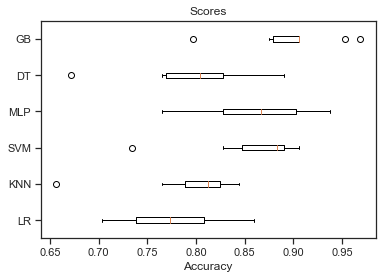

In [79]:
# Compare models
metric = 'Accuracy'
score = {'LR': cross_val_score(LogReg_fit, X_train[INPUTS_LR], y_train, cv=10, scoring='accuracy'), 
         'KNN': cross_val_score(knn_fit, X_train[INPUTS_KNN], y_train, cv=10, scoring='accuracy'),
         'SVM': cross_val_score(SVC_fit, X_train[INPUTS_RSVC], y_train, cv=10, scoring='accuracy'), 
         'MLP': cross_val_score(MLP_fit, X_train[INPUTS_MLP], y_train, cv=10, scoring='accuracy'),
         'DT': cross_val_score(tree_fit, X_train[INPUTS_DT], y_train, cv = 10,  scoring = 'accuracy'),
         'GB': cross_val_score(gb_clf_fit, X_train[INPUTS_GB], y_train, cv = 10,  scoring = 'accuracy')}
MT.dotplot(score, metric)

In [83]:
# Cross validation results (training and test accuracy obtained from the confusion matrix)
CVResults = [score['LR'].mean(), score['KNN'].mean(), score['SVM'].mean(), score['MLP'].mean(), score['DT'].mean(), score['GB'].mean()]
print(CVResults)
# MLP, SVM and GB show greater CV-accuracy than LR, KNN and Decision Trees.

[0.7734375, 0.796875, 0.8609375, 0.8640625, 0.8, 0.8984375]


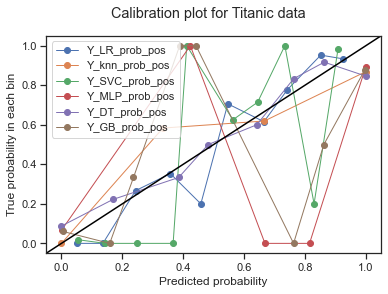

Area under the ROC curve of Y_LR_prob_pos : 0.889
Area under the ROC curve of Y_knn_prob_pos : 0.897
Area under the ROC curve of Y_SVC_prob_pos : 0.971
Area under the ROC curve of Y_MLP_prob_pos : 0.907
Area under the ROC curve of Y_DT_prob_pos : 0.876
Area under the ROC curve of Y_GB_prob_pos : 0.902


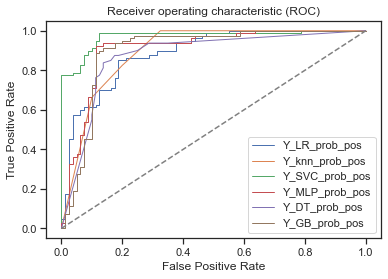

In [81]:
# Calibration plot for each model
CT.calibration_plot(y_test, dfTS_eval[['Y_LR_prob_pos','Y_knn_prob_pos', 'Y_SVC_prob_pos', 'Y_MLP_prob_pos', 'Y_DT_prob_pos', 'Y_GB_prob_pos']])
# As it can be seen in the plot, LR and KNN are the models whose probabilities are closer to the real ones while MLP and SVC probabilities are very distant from the real
# ones.

# Roc curve plot for each model
CT.roc_curve(y_test,  dfTS_eval[['Y_LR_prob_pos','Y_knn_prob_pos', 'Y_SVC_prob_pos', 'Y_MLP_prob_pos','Y_DT_prob_pos', 'Y_GB_prob_pos']], 1)
# On the other hand, MLP and SVC models have a greater AUC value than LR and KNN, tha menas they work better for most thresholds.

# Conclusions

+ SVM, MLP and Gradient Boosting gave better results than LR and KNN, better accuracy in CV, trainning and test. They showed a better Neg pred value in each of these sets too (these value is interesting as a false negative is the worst posible scenario).

+ SVM, MLP and Gradient Boosting  showed a greater difference in the trainning and test set than LR and KNN. That could be a consequence of SVM and MLP been complex and flexible models.

+ Eventhought MLP showed a better accuracy in CV and test than SVM, we would choose SVM because it shows better Neg pred value and because its explainability (MLP are considered blackbox).

+ But talking generally, Gradient Boosting is the best model with the highest accuraccy and the highest Negative Prediccion Value.